# plotting functions of figure 1 in the manuscript


In [1]:
# imports
import os
import re
import mrcfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from gemmi import cif

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_picking import (
    plot_precision, plot_recall, 
)


In [2]:
# functions
def get_resolution_from_logs(project_dir, data, verbose=False):
    results ={
        "Nparticles": [],
        "res_unmasked": [],
        "res": [],
    }
    
    # load the logfiles and retrieve the resolutions
    for _, item in data.items():
        if verbose:
            print(f"Processing {item['PostProcess']}")
        Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
        pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+(\.\d+)?)"
        with open(Refine3D_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res_unmasked = float(re.search(pattern, line).group(1))
                    break

        PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
        pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
        with open(PostProcess_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res = float(re.search(pattern, line).group(1))
                    break
        
        if verbose:
            print(f"Nparticles: {item['Nparticles']}")
            print(f"res_unmasked: {res_unmasked}")
            print(f"res: {res}")
        results["Nparticles"].append(item["Nparticles"])
        results["res_unmasked"].append(res_unmasked)
        results["res"].append(res)

    return results


## panel A
plot of the 2D classes generated during processing of the homogeneous (single-conformation) data. The 2D classification used here was done after the final reconstruction, for visualisation only and on the full-sized images (320x320).
plot of the FSC curve from RELION.

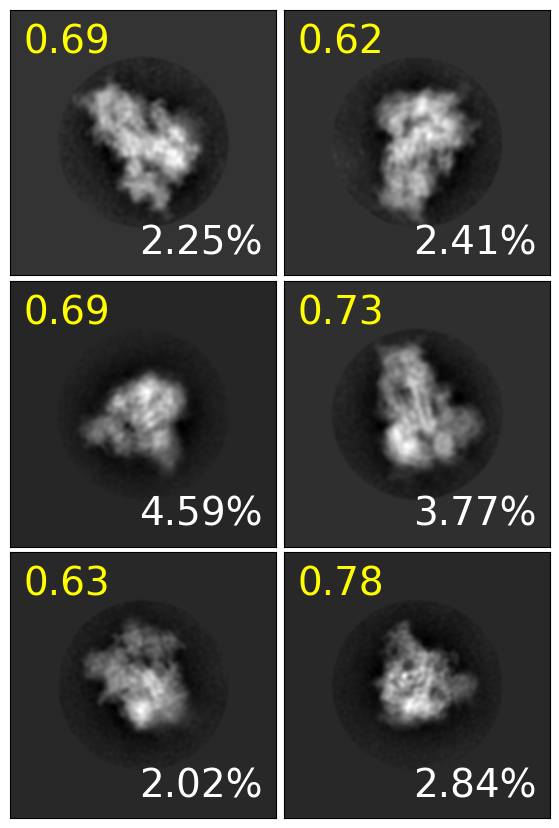

In [3]:
# parameters
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job042", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job043", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=28, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=28, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')

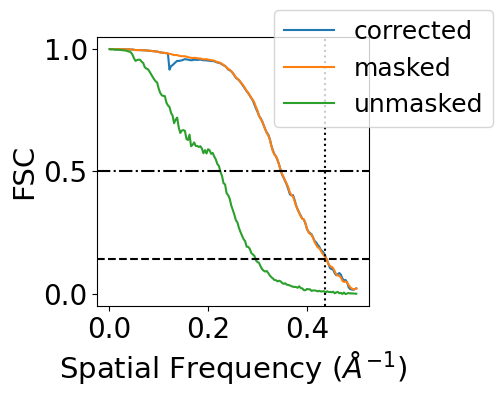

In [44]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
job = "job040"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
resolution = 2.29


fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected")
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked")
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked")
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18, bbox_to_anchor=(0.65, 1.1), loc=2, borderaxespad=0.)
fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")

## panel B
ResLog plot for single-conformation data set


B-factor masked: 17.77854567793456


/tmp/ipykernel_16663/4220091314.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


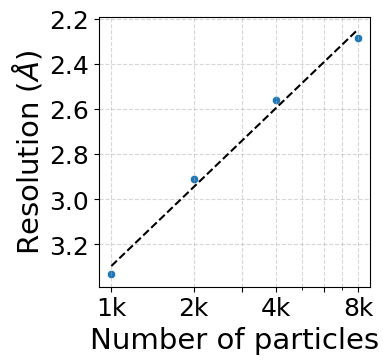

In [12]:
# data for single conformation set
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job037",
        "Refine3D": "job038",
        "MaskCreate": "job039",
        "PostProcess": "job040",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--")
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 3000, 4000, 6000, 8000])
ax.set_xticklabels(["1k", "2k", "", "4k", "", "8k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

fig.savefig(os.path.join(project_dir, "figures", "ResLog.pdf"), bbox_inches="tight")


## panel C
2D classes for the heterogeneous data set
FSC curve for the heterogeneous data set

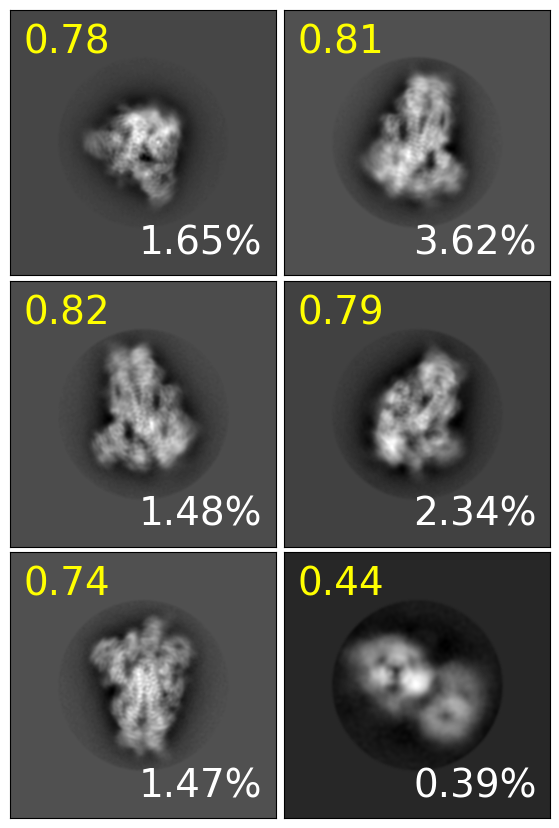

In [13]:
# parameters
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job058", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job060", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=28, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=28, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')


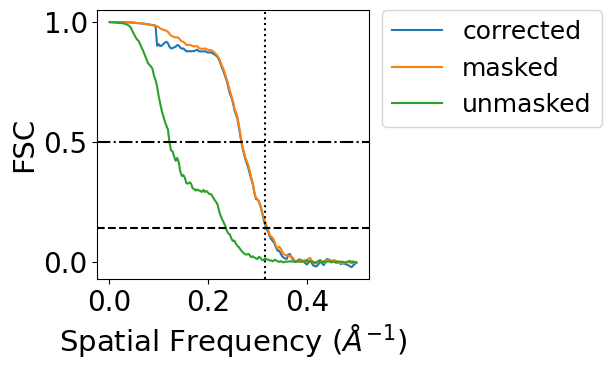

In [16]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
job = "job016"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
figures_dir = os.path.join(project_dir, "figures")
resolution = 3.17

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected")
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked")
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked")
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")

## panel D
ResLog plot for the heterogeneous data set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B-factor masked: 41.09042363473794


/tmp/ipykernel_16663/879455186.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


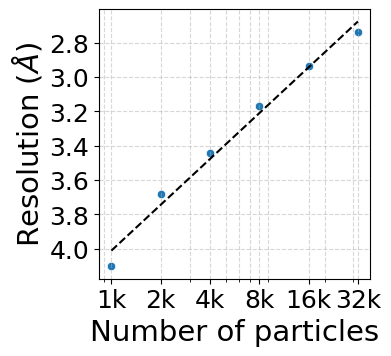

In [18]:
# data for full MD trajectory
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job006",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    6: {
        "Nparticles": 16000,
        "Select": "job050",
        "Refine3D": "job051",
        "MaskCreate": "job054",
        "PostProcess": "job055",
    },
    7: {
        "Nparticles": 32000,
        "Select": "job052",
        "Refine3D": "job053",
        "MaskCreate": "job056",
        "PostProcess": "job057",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data, False)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--")
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()
ax.legend().remove()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 4000, 8000, 16000, 32000])
ax.set_xticklabels(["1k", "2k", "4k", "8k", "16k", "32k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

fig.savefig(os.path.join(figures_dir, "ResLog.pdf"), bbox_inches="tight")


## panel E
plot of the resolution dependence on the number of frames of the MD trajectory that are included in the particles. The total number of particles remains constant at 4000

/tmp/ipykernel_16663/3016472314.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_Bfac.set_yticklabels(ax_Bfac.get_yticklabels(), fontsize=18)
/tmp/ipykernel_16663/3016472314.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_res.set_yticklabels(ax_res.get_yticklabels(), fontsize=18)


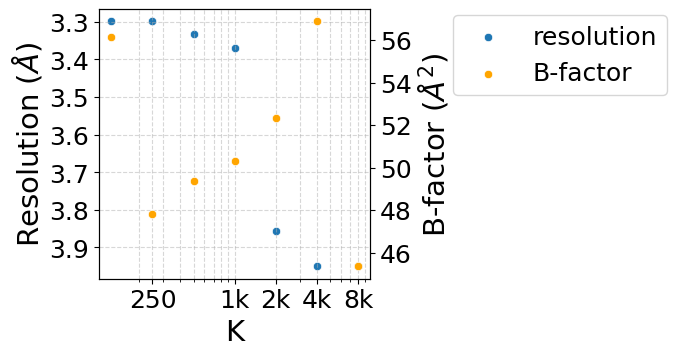

In [39]:
# define jobs to use
project_dir = "/home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "K": 125,
        "Nparticles": 4000,
        "Import": "job007",
        "Refine3D": "job009",
        "MaskCreate": "job010",
        "PostProcess": "job011",
    },
    1: {
        "K": 8000,
        "Nparticles": 4000,
        "Import": "job012",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    2: {
        "K": 250,
        "Nparticles": 4000,
        "Import": "job017",
        "Refine3D": "job019",
        "MaskCreate": "job020",
        "PostProcess": "job021",
    },
    3: {
        "K": 500,
        "Nparticles": 4000,
        "Import": "job022",
        "Refine3D": "job024",
        "MaskCreate": "job025",
        "PostProcess": "job026",
    },
    4: {
        "K": 1000,
        "Nparticles": 4000,
        "Import": "job027",
        "Refine3D": "job029",
        "MaskCreate": "job030",
        "PostProcess": "job031",
    },
    5: {
        "K": 2000,
        "Nparticles": 4000,
        "Import": "job032",
        "Refine3D": "job034",
        "MaskCreate": "job035",
        "PostProcess": "job036",
    },
    6: {
        "K": 4000,
        "Nparticles": 4000,
        "Import": "job037",
        "Refine3D": "job039",
        "MaskCreate": "job040",
        "PostProcess": "job041",
    },
}

results = {
    "K": [],
    "Nparticles": [],
    "res_unmasked": [],
    "res": [],
    "B_fac": [],
}

# loop over the jobs and get the resolution and B-factor from the log files
for _, item in data.items():
    Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
    pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+\.\d+)"
    with open(Refine3D_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res_unmasked = float(re.search(pattern, line).group(1))
                break

    PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
    pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res = float(re.search(pattern, line).group(1))
                break
    
    pattern = r"\+\s*apply\s+b-factor\s+of:\s+(-?\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                B_fac = float(re.search(pattern, line).group(1))
                break

    results["K"].append(item["K"])
    results["Nparticles"].append(item["Nparticles"])
    results["res_unmasked"].append(res_unmasked)
    results["res"].append(res)
    results["B_fac"].append(-B_fac)
    # results["localres_std"].append(localres_std)

results_df = pd.DataFrame(results)
    
# plot the results
fig, ax_res = plt.subplots(figsize=(3.5, 3.5))
ax_Bfac = ax_res.twinx()
sns.scatterplot(
    data=results_df, x="K", y="res", ax=ax_res, label="resolution"
)
sns.scatterplot(
    data=results_df, x="K", y="B_fac", ax=ax_Bfac, label="B-factor", color="orange"
)
ax_res.set_xlabel("K", fontsize=21)
ax_res.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax_res.set_xscale("log")
ax_res.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# ax_res.set_ylim((3.0, 4.1))
ax_res.invert_yaxis()
ax_Bfac.set_ylabel("B-factor ($\AA^2$)", fontsize=21)
# ax_Bfac.set_ylim((40, 65))
# remove legends from the axis and add a single legend
ax_res.get_legend().remove()
ax_Bfac.get_legend().remove()
fig.legend(loc="upper left", bbox_to_anchor=(1.1, 0.90), ncol=1, fontsize=18)

ax_Bfac.set_yticklabels(ax_Bfac.get_yticklabels(), fontsize=18)
ax_res.set_yticklabels(ax_res.get_yticklabels(), fontsize=18)
ax_res.set_xticks([250, 1000, 2000, 4000, 8000])
ax_res.set_xticklabels(["250", "1k", "2k", "4k", "8k"], fontsize=18)

fig.savefig(os.path.join(figures_dir, "resolution_Bfactor_vs_K.pdf"), bbox_inches="tight")


## panel F
plot of the particle picking precision and recall throughout the processing of the heterogeneous data set

In [45]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
config_dir = os.path.join(project_dir, "Micrographs")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "Extract", "job007", "particles.star"),
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"),
    os.path.join(project_dir, "Select", "job009", "particles.star"),
    os.path.join(project_dir, "Select", "job036", "particles.star"),
    os.path.join(project_dir, "Select", "job037", "particles.star"),
    os.path.join(project_dir, "Select", "job038", "particles.star"),
    os.path.join(project_dir, "Select", "job039", "particles.star"),
    # os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"),
    # os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"),
    # os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job007", "particles.star"): "topaz picker",
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"): "2D classification",
    os.path.join(project_dir, "Select", "job009", "particles.star"): "2D class selection",
    os.path.join(project_dir, "Select", "job036", "particles.star"): "3D class 0",
    os.path.join(project_dir, "Select", "job037", "particles.star"): "3D class 1",
    os.path.join(project_dir, "Select", "job038", "particles.star"): "3D class 2",
    os.path.join(project_dir, "Select", "job039", "particles.star"): "3D class 3",
    os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"): "Homogeneous refinement 1",
    os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"): "Homogeneous refinement 2",
    os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"): "Homogeneous refinement 3",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
print(f"mean precision: {df_precision['precision'].mean()}")
print(f"mean recall: {df_precision['recall'].mean()}")


loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star...


loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star. determined file type: star


Dictionaries now contain 240974 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star


loading truth data: 100%|██████████| 900/900 [05:55<00:00,  2.53it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 240974 particles and 270000 true particles
Added 270000 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 481948 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/D

computing precision: 100%|██████████| 6300/6300 [05:25<00:00, 19.33it/s, precision=1, recall=0.193, multiplicity=0.207]    


time taken to compute precision: 328.6037106513977
mean precision: 0.997717998958324
mean recall: 0.5379248099604771


/home/mjoosten1/projects/roodmus/src/roodmus/analysis/plot_picking.py:401: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/mjoosten1/projects/roodmus/src/roodmus/analysis/plot_picking.py:435: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_16663/3538534384.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, fontsize=12)
/tmp/ipykernel_16663/3538534384.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_16663/3538534384.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/home/mjoosten1/projects/roodmus/src/roodmus/analysis/

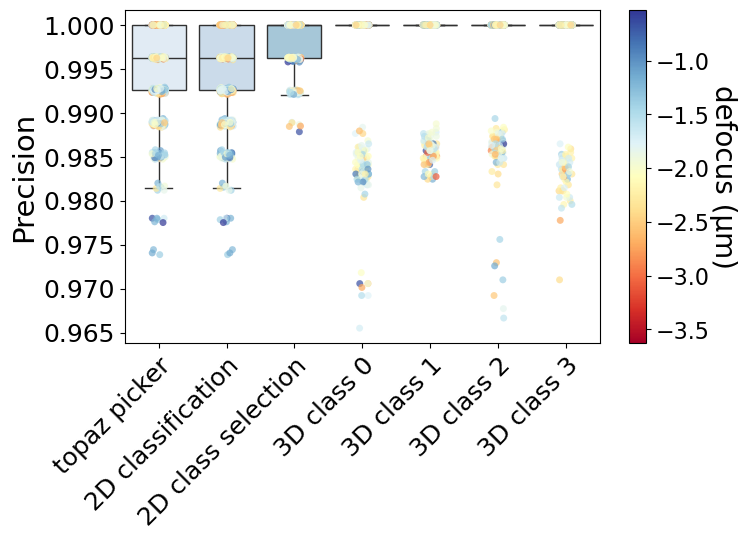

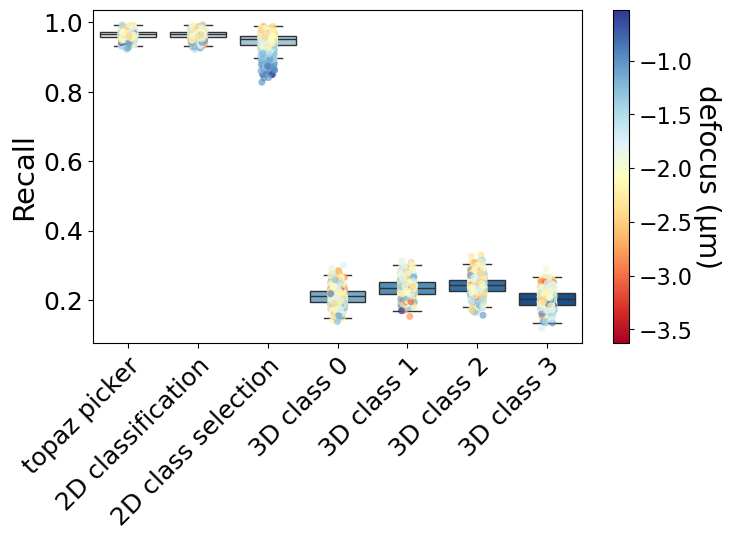

In [62]:
from importlib import reload
import roodmus.analysis.plot_picking
reload(roodmus.analysis.plot_picking)
from roodmus.analysis.plot_picking import (
    plot_precision, plot_recall,
)

order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])  
fig, ax = plot_precision(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Precision", fontsize=21)

fig.savefig(os.path.join(figures_dir, "precision.pdf"), bbox_inches="tight")

fig, ax = plot_recall(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Recall", fontsize=21)

fig.savefig(os.path.join(figures_dir, "recall.pdf"), bbox_inches="tight")

